# Gravity Gradiometer Signal Model

The purpose of this script is to estimate the signal detected by a differential gravity sensor (gravity gradiometer) for a given ground mass distribution and at a given altitude. The model is structured as follows:

- Libraries and basic functions
- Space and mass map creation
- calculation of signal from single sensors
- gravity maps and gravity gradient map

## _TO DO_:
- consider changing mass_elements, polar map, into 2D array rather than lists. I guess it is not a problem, as long as they map together. However, that gets more complicated when plotting, doing operations, etc.

## Imports

In [155]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Constants and physical values

In [4]:
Gconst = 6.67408 *10**(-11) #N⋅m2/kg2 - Gravitational constant
densitydiff=1  # a parameter adjusting contrast between features.
#angle=1 # angle multiplier factor
#r =1

bias = 3*10**(-6) #earth's contribution 3000 E in terms of gravity gradient
l = 10 # lenght of map matrix element in km
elev = 5 # matrix element height, important for the absolute quantities measured
esd= 3000 # density of earth's surface, kg per cubic metre

## Map Generation

### Random mass distribution map

In [71]:
x_size = 51 
y_size = 401
"""Factors specifying the dimensions of the map. Bear in mind that the map size needs to be compatible with the satellite 
path, i.e. the satellite coordinates must fall within the map coordinates domain."""

x=np.arange(0,x_size,1)
y=np.arange(0,y_size,1)
X,Y = np.meshgrid(x,y)

#dmap=np.random.randn(len(X),len(Y)) # creating a table of random mass distribution, mean is 0, st dev 1
dmap=np.random.randn(x_size,y_size)

In [126]:
coordinates_map = [[[a,b] for b in y ]for a in x] # list of tuples with coordinates pair for each element of the space matrix
coordinates_map_array = np.array(coordinates_map)

In [121]:
massmap = dmap * l**2 *elev*esd
#mass_elements = [(massmap[i][j]) for i in range(massmap.shape[0]) for j in range(massmap.shape[1])]

### Map export

In [7]:
np.savetxt('maps/random_massmap.txt', massmap)

## Map import

A map matrix can be imported from file, if generated independently.

## Satellite positions
### Manual setting

In [170]:
altitude = 200 # km
baseline = 0.001 # i.e. 1 m
#satellite reference location
xs = 50
ys = 50
x_range=np.arange(xs-10,xs+11,2)
y_range=np.arange(xs-10,xs+12,2)
satellite_positions = [(x,y) for x in x_range for y in y_range]

### Automatic and even-spaced calculation of satellite positions
By setting the number of positions on each axis the function generates a list of coordinates.

## Gravity Signal Function

In [10]:
G_meas_survey=np.empty([len(x_range),len(y_range)])  
# initialisation of an empty array, to be populated with gravity measurements

In [168]:
def polar_coordinates(x_i,y_i,x_s,y_s,altitude):
    """
    x_s,y_s : satellite reference position
    x_i,y_i : map location of interest
    altitude : satellite altitude  
    r,angle : coordinates of the map location with respect to the satellite, in polar geometry.
    """
    
    ground_dist = math.sqrt(abs(x_i-xs)**2 + abs(y_i-ys)**2) * l
    r = math.sqrt(altitude**2 + ground_dist**2)
    angle = math.atan(ground_dist/altitude)
    
    return r,angle

def polar_map(coordinates_map,x_s,y_s,altitude):
    """
    function returning a list of tuples each made of
    (radial distance, angle)
    with respect to a satellite position
    """
    #coordinates_map = [[[a,b] for b in y ]for a in x]  x size 51, y size 401
    pol_map = np.array([[polar_coordinates(coordinates_map[i][j][0],coordinates_map[i][j][1],x_s,y_s,altitude) 
                         for j in range(len(coordinates_map[0]))] for i in range(len(coordinates_map))])
    return pol_map


def gravity_force_1D(Gconst,mass_map,pol_map):

    #g_obj=math.cos(angle)*Gconst*mass/r**2 #to be verified
    
    G_force_map = [[math.cos(pol_map[i][j][1])*Gconst*mass_map[i][j]/pol_map[i][j][0]**2 for j in range(len(mass_map[0]))] for i in range(len(mass_map))]  
    """
    iterate the formula over mass map and polar coordinates.
    Each element represents the contribution to the gravity force from a single mass map matrix element. The sum is the total force
    """
    grav_pull=sum(sum(GM))
    return grav_pull,np.array(G_force_map)

## Signal Calculation and final result
### First satellite

## _Testing functions_

In [169]:
grav_pull,GM = gravity_force_1D(Gconst,massmap,pm)

In [142]:
pm=polar_map(coordinates_map_array,50,50,altitude)

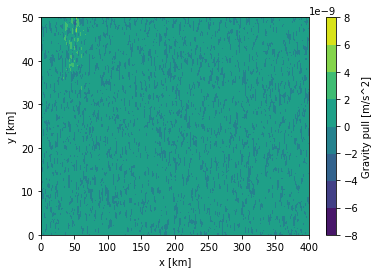

In [165]:
fig, ax = plt.subplots()
cs = ax.contourf(y, x, GM)
cbar = fig.colorbar(cs)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
cbar.set_label('Gravity pull [m/s^2]')
plt.show()